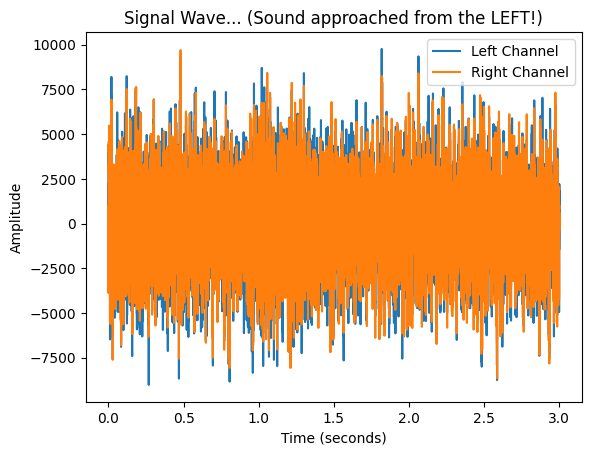

Sound approached from the LEFT!
[-1.8188216e+02  1.8057683e+02 -1.9772379e+01  6.6669388e+00
  7.0560980e+00  1.1246623e+01 -3.9668847e-02  1.2637466e+01
 -3.9179912e-01  4.3227754e+00 -6.0214195e+00  1.9204813e+00
 -1.2218918e+00  3.8689992e+00 -2.5978880e+00  4.3898087e+00
 -8.3583623e-01  2.2907174e+00 -1.1552112e+00  4.5409613e+00
 -4.1247174e-01  5.3851523e+00 -5.1694119e-01  4.9782252e+00
 -1.0400552e-01  3.9126968e+00 -1.9360609e-01  3.7268534e+00
  8.5529976e-02  3.0994015e+00 -5.2735037e-01  1.7955045e+00
 -1.2615408e+00  2.2472015e-02 -2.0292029e+00  3.0693042e-01
 -2.7499135e+00  1.6160034e+00 -1.3931013e+00  1.5084023e+00
 -1.3278135e+00  2.8666365e+00 -2.8118861e-01  2.2440834e+00
 -1.3235943e-01  3.5343089e+00  2.0056888e-01  1.3067207e+00
 -7.7713072e-01  1.2995238e+00 -8.3504683e-01  1.5006307e+00
 -1.7459978e+00  2.1416958e-01 -2.4522607e+00  5.2148765e-01
 -3.5741010e+00  1.2768425e-01 -2.2101779e+00  9.1128987e-01
 -1.5664647e+00  1.2118633e+00 -7.9818487e-01  4.1522

In [18]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
import matplotlib.pyplot as plt
import wave

# Load the pre-trained model
siren_CNN_model = load_model('siren_CNN_model.h5')

filename = "C:/SARANI/AIES/MINI Project/sounds/traffic/sound_490.wav"

with wave.open(filename, 'r') as wav_file:
    # Extract raw audio from wav file
    signal = wav_file.readframes(-1)
    signal = np.frombuffer(signal, dtype=np.int16)

    # Split the data into channels
    channels = [[] for channel in range(wav_file.getnchannels())]
    for index, datum in enumerate(signal):
        channels[index % len(channels)].append(datum)

    # Get time from indices
    fs = wav_file.getframerate()
    num_samples = len(signal) // len(channels)  # Ensure integer division
    Time = np.linspace(0, num_samples / fs, num=num_samples)

    # Calculate the sum of absolute values (total intensity) for each channel
    left_channel_intensity = np.sum(np.abs(channels[0]))
    right_channel_intensity = np.sum(np.abs(channels[1]))

    # Determine direction based on higher intensity
    if left_channel_intensity > right_channel_intensity:
        direction = "Sound approached from the LEFT!"
        dir = "left"
    elif right_channel_intensity > left_channel_intensity:
        direction = "Sound approached from the RIGHT!"
        dir = "right"
    else:
        direction = "Sound is centered."
        dir = "center"

    # Plot the signal
    plt.figure(1)
    plt.title('Signal Wave... (' + direction + ')')
    
    plt.plot(Time, channels[0], label='Left Channel')
    plt.plot(Time, channels[1], label='Right Channel')
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    
    # Show the plot
    plt.show()

    # Print the determined direction
    print(direction)

audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

# Predict the probabilities
predicted_probabilities = siren_CNN_model.predict(mfccs_scaled_features)
# Get the class with the highest probability
predicted_label = np.argmax(predicted_probabilities, axis=1)
print(predicted_label)

label_encoder = LabelEncoder()
label_encoder.fit(['ambulance', 'firetruck', 'traffic'])

prediction_class = label_encoder.inverse_transform(predicted_label) 
print(prediction_class)

In [19]:
import requests

# # Prediction code
# label_encoder = LabelEncoder()
# label_encoder.fit(['ambulance', 'firetruck', 'traffic'])
# prediction_class = label_encoder.inverse_transform(predicted_label)
# print(prediction_class)

# Send classification result to ESP32 via HTTP POST
esp32_ip = "http://192.168.43.30"  # Replace with your ESP32's IP address
endpoint = f"{esp32_ip}/classify"

data = {'classification': prediction_class[0], 'direction': dir}

# Send the POST request to ESP32
response = requests.post(endpoint, data=data)
print("Response from ESP32:", response.text)


Response from ESP32: Classification and direction received
